In [207]:



import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.nn import relu
# from jax.config import config
from jax.nn import relu, gelu, selu

from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt


import scipy.io as sio
from sklearn.model_selection import train_test_split

%matplotlib inline


In [208]:
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [209]:
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers, equation_type):    
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=gelu)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=gelu)

        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        
        self.equation_type = equation_type
        
        # Initialize PDE parameters as well
        if equation_type == 'standard_fisher':
            pde_params = {
                'D0': np.log(np.array(1300.0)),
                'r': np.log(np.array(0.3)),
                'K': np.log(np.array(2600.0)),
            }
    
        elif equation_type == 'porous_fisher':
            pde_params = {
                'D0': np.log(np.array(1300.0)),
                'r': np.log(np.array(0.3)),
                'K': np.log(np.array(2600.0)),
                'eta': np.log(np.array(1e-4)),  
            }
        
        elif equation_type == 'richards':
            pde_params = {
                'D0': np.log(np.array(1300.0)),
                'r': np.log(np.array(0.3)),
                'K': np.log(np.array(2600.0)),
                'gamma': np.log(np.array(1.0)), 
            }
        
        elif equation_type == 'generalized_fisher':
            pde_params = {
                'D0': np.log(np.array(1300.0)),
                'r': np.log(np.array(0.3)),
                'K': np.log(np.array(2600.0)),
                'alpha': np.log(np.array(1.0)),
                'beta': np.log(np.array(1.0)),
            }

        params = (branch_params, trunk_params, pde_params)

        self.opt_init, self.opt_update, self.get_params = optimizers.adam(
            optimizers.exponential_decay(1e-3, decay_steps=2000, decay_rate=0.9)
        )
        self.opt_state = self.opt_init(params)

        _, self.unravel_params = ravel_pytree(params)
        self.itercount = itertools.count()

        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    def operator_net(self, params, u, x, y, t):
        # Just remember that now params = (branch_params, trunk_params, pde_params)
        branch_params, trunk_params, _ = params
        
        u = np.atleast_1d(u)
        x = np.atleast_1d(x)
        y = np.atleast_1d(y)
        t = np.atleast_1d(t)

        u = u.reshape(-1, 1)
        Y = np.column_stack([x, y, t])

        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, Y)
        outputs = np.sum(B * T, axis=1)

        if outputs.size == 1:
            return outputs[0]
        return outputs

    def residual_net(self, params, u, x, y, t):
        _, _, pde_params = params
        D0 = pde_params['D0']
        r = pde_params['r']
        K = pde_params['K']

        # Helper function to compute gradients of the operator with respect to different arguments
        def compute_grad(argnums, order=1):
            grad_fn = self.operator_net
            for _ in range(order):
                grad_fn = grad(grad_fn, argnums=argnums)
            return grad_fn(params, u, x, y, t)

        # Compute the operator output
        s = self.operator_net(params, u, x, y, t)

        # Compute the required gradients
        s_t = compute_grad(argnums=4, order=1)  # Time derivative
        s_xx = compute_grad(argnums=2, order=2)  # Second X derivative
        s_yy = compute_grad(argnums=3, order=2)  # Second Y derivative

        if self.equation_type == 'standard_fisher':
            # Standard Fisher-KPP equation: s_t = D0 * (s_xx + s_yy) + r * s * (1 - s / K)
            res = s_t - D0 * (s_xx + s_yy) - r * s * (1 - s / K)

        elif self.equation_type == 'porous_fisher':
            # Porous Fisher-KPP equation: s_t = D0 * (s_xx + s_yy) + r * s * (1 - s / K) + eta * (s_xx + s_yy)
            eta = pde_params.get('eta', 1.0)
            res = s_t - D0 * (s_xx + s_yy) - r * s * (1 - s / K) + eta * (s_xx + s_yy)

        elif self.equation_type == 'richards':
            # Richards equation: s_t = D0 * (s_xx + s_yy) + r * s * (1 - s / K) - gamma * (s_xx + s_yy)
            gamma = pde_params.get('gamma', 1.0)
            res = s_t - D0 * (s_xx + s_yy) - r * s * (1 - s / K) - gamma * (s_xx + s_yy)

        elif self.equation_type == 'generalized_fisher':
            # Generalized Fisher-KPP equation: s_t = D0 * (s_xx + s_yy) + r * s * (1 - s / K) + alpha * s_xx + beta * s_yy
            alpha = pde_params.get('alpha', 1.0)
            beta = pde_params.get('beta', 1.0)
            res = s_t - D0 * (s_xx + s_yy) - r * s * (1 - s / K) + alpha * s_xx + beta * s_yy

        return res
        

    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, Y = inputs
        x, y_coord, t = Y[:,0], Y[:,1], Y[:,2]
        s_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, u, x, y_coord, t)
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss

    def loss_res(self, params, batch):
        inputs, outputs = batch
        u, Y = inputs
        x, y_coord, t = Y[:,0], Y[:,1], Y[:,2]
        pred = vmap(self.residual_net, (None, 0, 0, 0, 0))(params, u, x, y_coord, t)
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss

    def loss(self, params, bcs_batch, res_batch):
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        return loss_bcs + 1e-2 * loss_res

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    def train(self, bcs_dataset, res_dataset, nIter):
        for (u_batch, y_batch), s_batch in bcs_dataset:
            print("BCS batch shapes:")
            print("u_batch:", u_batch.shape)
            print("y_batch:", y_batch.shape)
            print("s_batch:", s_batch.shape)
            break

        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        for it in pbar:
            bcs_batch = next(bcs_data)
            res_batch = next(res_data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch)

            # Log every iteration or adjust frequency as needed
            params = self.get_params(self.opt_state)
            loss_value = self.loss(params, bcs_batch, res_batch)
            loss_bcs_value = self.loss_bcs(params, bcs_batch)
            loss_res_value = self.loss_res(params, res_batch)

            # Compute maximum output of the operator_net for the current batch
            u, Y = bcs_batch[0]
            x, y, t = Y[:, 0], Y[:, 1], Y[:, 2]
            s_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, u, x, y, t)
            max_output = np.max(s_pred)
            
            _, _, pde_params = params
    
            self.loss_log.append(loss_value)
            self.loss_bcs_log.append(loss_bcs_value)
            self.loss_res_log.append(loss_res_value)
            postfix = {'Loss': loss_value,
                        'loss_bcs': loss_bcs_value,
                        'loss_physics': loss_res_value,
                        'max_output': max_output,
                      }
            postfix.update({par: np.exp(val) for par,val in pde_params.items()})
            pbar.set_postfix(postfix)


    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(
            params, U_star, Y_star[:,0], Y_star[:,1], Y_star[:,2]
        )
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0, 0))(
            params, U_star, Y_star[:,0], Y_star[:,1], Y_star[:,2]
        )
        return r_pred
    
    


In [210]:

nx, ny = 150, 150
N_t = 77
L_left, L_right = 0, 4380
N_point = nx * ny


Readin Data

In [211]:
j = 3
def get_dataset(experiment_idx):
    print(f"Processing dataset {j}...")

    # Initialize arrays for grid and simulation data
    U_total = np.zeros((N_point * N_t, 1))
    X_total = np.zeros((N_point * N_t, 1))
    Y_total = np.zeros((N_point * N_t, 1))
    T_total = np.zeros((N_point * N_t, 1))

    # Generate the grid for x, y, and time (t)
    for i in range(N_t):
        x = np.linspace(L_left, L_right, nx)
        y = np.linspace(L_left, L_right, ny)
        X, Y = np.meshgrid(x, y)
        T = np.full((N_point, 1), i * 20)

        indices = np.arange(i * N_point, (i + 1) * N_point)
        X_total = X_total.at[indices, :].set(X.reshape(-1, 1))
        Y_total = Y_total.at[indices, :].set(Y.reshape(-1, 1))
        T_total = T_total.at[indices, :].set(T)

    # Define input and output file paths
    input_file = f'./Data/U_total_{j}.mat'
    output_file = f'./MeshData/TriangularMesh/U_xy{j}.mat'
    if j in [1, 2, 5, 6]: 
        output_file = f'./MeshData/CircularMesh/U_xy{j}.mat'

    # Load simulation data from the .mat file
    U = sio.loadmat(input_file)
    U_data = np.array(U[f'U_{j}'][:N_point * N_t, 0])[:, None] 

    # Combine X, Y, T, and U into a single array
    U_xy = np.hstack([X_total, Y_total, T_total, U_data])

    return U_xy



In [212]:
def preprocess_data(data):
    """
    Normalize the columns of the dataset: x, y, t, u.
    Returns the normalized data along with min and max values for each feature.
    """
    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    y_min, y_max = data[:, 1].min(), data[:, 1].max()
    t_min, t_max = data[:, 2].min(), data[:, 2].max()
    u_min, u_max = data[:, 3].min(), data[:, 3].max()

    data = data.at[:, 0].set((data[:, 0] - x_min) / (x_max - x_min))
    data = data.at[:, 1].set((data[:, 1] - y_min) / (y_max - y_min))
    data = data.at[:, 2].set((data[:, 2] - t_min) / (t_max - t_min))
    data = data.at[:, 3].set((data[:, 3] - u_min) / (u_max - u_min))
    
    return data

def split_and_preprocess_dataset(mesh_type, j):
    """
    Splits and preprocesses the dataset based on mesh type.
    Returns the preprocessed training and testing data along with min/max values.
    """
    data = get_dataset(j)
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

    # Normalize train and test data
    train_data = preprocess_data(train_data)
    test_data = preprocess_data(test_data)

    # Extract features (x, y, t, u) from train and test data
    x_train, y_train, t_train, u_train = train_data[:, 0], train_data[:, 1], train_data[:, 2], train_data[:, 3]
    x_test, y_test, t_test, u_test = test_data[:, 0], test_data[:, 1], test_data[:, 2], test_data[:, 3]

    # Output the dataset shape
    if mesh_type == 'circular':
        print(f"CircularMesh - Training Data Shape: {train_data.shape}")
        print(f"CircularMesh - Testing Data Shape: {test_data.shape}")
    else:
        print(f"TriangularMesh - Training Data Shape: {train_data.shape}")
        print(f"TriangularMesh - Testing Data Shape: {test_data.shape}")
    
    return x_train, x_test, y_train, y_test, t_train, t_test, u_train, u_test

# Main processing loop
if j in [1, 2, 5, 6]:
    # Circular mesh type processing
    mesh_type = 'circular'
else:
    # Triangular mesh type processing
    mesh_type = 'triangular'

# Process the dataset based on mesh type
x_train, x_test, y_train, y_test, t_train, t_test, u_train, u_test = split_and_preprocess_dataset(mesh_type, j)


Processing dataset 3...
TriangularMesh - Training Data Shape: (1386000, 4)
TriangularMesh - Testing Data Shape: (346500, 4)


In [213]:
def shuffle_data(x, y, t, u, random_key):
    """
    Shuffle the data arrays (x, y, t, u) based on a random key.
    """
    num_samples = x.shape[0]
    indices = random.choice(random_key, num_samples, (num_samples,), replace=False)
    return x[indices], y[indices], t[indices], u[indices]

def select_boundary_conditions(x, y, t, u, condition_value):
    """
    Select boundary conditions where t == condition_value.
    """
    condition_indices = np.where(t == condition_value)[0]
    selected_x = x[condition_indices]
    selected_y = y[condition_indices]
    selected_u = u[condition_indices]
    selected_t = t[condition_indices]
    
    y_bcs = np.hstack([selected_x.reshape(-1, 1), selected_y.reshape(-1, 1), selected_t.reshape(-1, 1)])
    return selected_u, y_bcs, selected_u  # Return u_bcs, y_bcs, and s_bcs (which is just u)

def select_residual_points(x, y, t, u):
    """
    Select all residual points without any limit.
    """
    u_res = u
    y_res = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1), t.reshape(-1, 1)])
    s_res = u
    return u_res, y_res, s_res

def prepare_kpp_training_data(x_d, y_d, t_d, u_d, random_key):
    """
    Prepare boundary and residual training data for KPP-Fisher equation.
    This function handles the shuffling, boundary condition extraction, 
    and residual point sampling.
    """
    # Shuffle data
    x_d, y_d, t_d, u_d = shuffle_data(x_d, y_d, t_d, u_d, random_key)

    # Boundary condition: Select points at t=0
    u_bcs_train, y_bcs_train, s_bcs_train = select_boundary_conditions(x_d, y_d, t_d, u_d, 0)

    # Residual points: Select all points without limit
    u_res_train, y_res_train, s_res_train = select_residual_points(x_d, y_d, t_d, u_d)

    return u_bcs_train, y_bcs_train, s_bcs_train, u_res_train, y_res_train, s_res_train


In [214]:
key = random.PRNGKey(0)

# Prepare training data using the loaded dataset
u_bcs_train, y_bcs_train, s_bcs_train, u_res_train, y_res_train, s_res_train = prepare_kpp_training_data(
    x_train,
    y_train,
    t_train,
    u_train,
    key
)

print(f"Boundary conditions shape: u={u_bcs_train.shape}, y={y_bcs_train.shape}, s={s_bcs_train.shape}")
print(f"Residual points shape: u={u_res_train.shape}, y={y_res_train.shape}, s={s_res_train.shape}")


Boundary conditions shape: u=(18001,), y=(18001, 3), s=(18001,)
Residual points shape: u=(1386000,), y=(1386000, 3), s=(1386000,)


In [215]:
class DataGenerator:
    def __init__(self, u_data, y_data, s_data, batch_size, key):
        self.u_data = u_data
        self.y_data = y_data
        self.s_data = s_data
        self.batch_size = batch_size
        self.num_samples = u_data.shape[0]
        self.indices = np.arange(self.num_samples)
        self.key = key

    def __iter__(self):
        # Loop infinitely
        while True:
            self.indices = random.permutation(self.key, self.indices)
            for start_idx in range(0, self.num_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, self.num_samples)
                batch_indices = self.indices[start_idx:end_idx]
                u_batch = self.u_data[batch_indices]
                y_batch = self.y_data[batch_indices]
                s_batch = self.s_data[batch_indices]
                yield (u_batch, y_batch), s_batch


In [220]:


key = random.PRNGKey(1234)


branch_layers = [1, 50, 50, 50, 50, 50]
trunk_layers = [3, 50, 50, 50, 50, 50]  # Trunk uses 3 inputs: x, y, t
model = PI_DeepONet(branch_layers, trunk_layers, 'generalized_fisher')

batch_size = 1000

bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size, key)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size , key)

model.train(bcs_dataset, res_dataset, nIter=100)

y_test_combined = np.hstack([
    x_test.reshape(-1, 1), 
    y_test.reshape(-1, 1), 
    t_test.reshape(-1, 1)
])  # shape: (N, 3)

params = model.get_params(model.opt_state)

s_pred = model.predict_s(params, u_test, y_test_combined)
s_pred = s_pred.reshape(u_test.shape)


print("Predicted outputs range:")
print(f"Min: {s_pred.min()}, Max: {s_pred.max()}")

print("True outputs range:")
print(f"Min: {u_test.min()}, Max: {u_test.max()}")


error_s = np.linalg.norm(u_test - s_pred) / np.linalg.norm(u_test)
print(f"Mean relative L2 error: {error_s:.2e}")



BCS batch shapes:
u_batch: (1000,)
y_batch: (1000, 3)
s_batch: (1000,)


100%|██████████| 100/100 [02:06<00:00,  1.27s/it, Loss=0.00022285475, loss_bcs=0.00021837353, loss_physics=0.0004481212, max_output=0.93682885, D0=1275.7115, K=2548.2935, alpha=1.0232066, beta=1.0154479, r=0.30378887]   


Predicted outputs range:
Min: 0.0012496388517320156, Max: 1.040779709815979
True outputs range:
Min: 0.0, Max: 1.0
Mean relative L2 error: 8.95e-02


In [219]:
branch_params, trunk_params, pde_params = params

# PDE parameters are stored in pde_params dictionary
print("Estimated PDE parameters:")

for par, val in pde_params.items():
    print(f'{par}: {np.exp(val)}')


Estimated PDE parameters:
D0: 1261.16064453125
K: 2585.27783203125
eta: 0.00010308001219527796
r: 0.30101704597473145


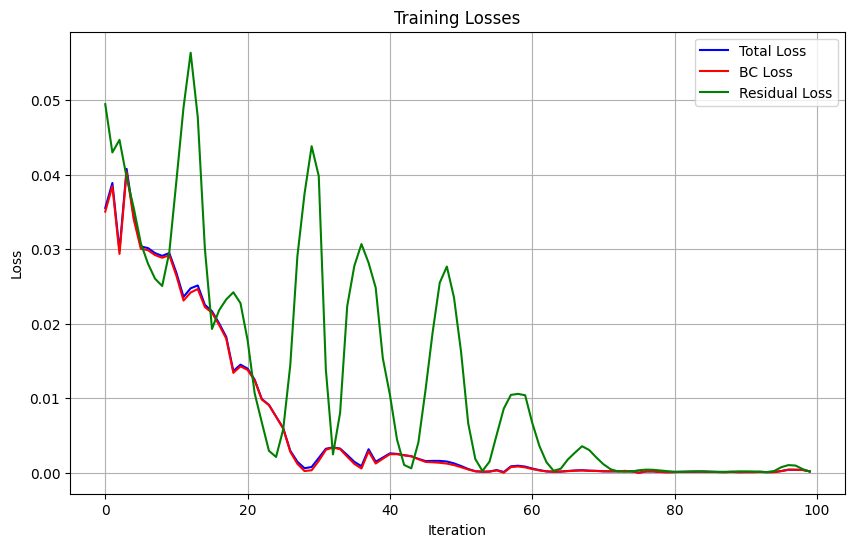

In [218]:
iterations = range(len(model.loss_log))  

plt.figure(figsize=(10, 6))
plt.plot(iterations, model.loss_log, label='Total Loss', color='blue')
plt.plot(iterations, model.loss_bcs_log, label='BC Loss', color='red')
plt.plot(iterations, model.loss_res_log, label='Residual Loss', color='green')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.show()